# Temporal Feature Analysis Demo

Welcome to [Temporal Feature Analysis](https://arxiv.org/abs/2511.01836), this notebook demonstrates how to get started.

Temporal Feature Analysis is an interpretability method designed to capture both contextual and local information in language model representations. The method is based on the hypothesis that language models build up an aggregate context representation through the input sequence, and each new token provides a sparse update. Specifically, the activation `x_t` at token position `t`is a sum `x_t = x_{p,t} + x_{n,t}` of a representation of context `x_{p,t}` (p for "predictive") and a representation of novel informantion `x_{n,t}`. The Figure below illustrates how Temporal Feature Analysis uses an attention layer to predict `x_{p,t}` and a Sparse Autoencoder to reconstruct `x_{n,t} = x_t - x_{p,t}`. We find that the corresponding feature code `z_{p,t}` captures long-term informations, like event boundaries in stories, while `z_{n,t}` captures local concepts similar to existing SAEs. Note: We use the terms *context code* and *predictive code* interchangeably.

<div style="background-color: white; padding: 10px; display: inline-block;">
  <img src="img/architecture.png" alt="Architecture">
</div>

**Content of this notebook**

- Loading a pretrained Temporal Feature Analyzer (TFA)
- Extracting predictive and novel codes from language model activations
- Feature dashboard for novel codes
- Similarity matrix for predictive codes
- UMAP for predictive codes


**Learn more**

- [Pre-print on Arxiv](https://arxiv.org/abs/2511.01836)
- [Interactive demo on Neuronpedia](https://www.neuronpedia.org/gemma-2-2b/12-temporal-res?simMatrixDemo=alice-maya)
- [Training repo on GitHub](https://github.com/eslubana/TemporalFeatureAnalysis)
- [Pretrained weights on Huggingface](https://huggingface.co/canrager/temporalSAEs/tree/main)

# Setup

Run the cells in the following section to setup the notebook environment. Logging in to your Huggingface Account via `notebook_login()` is necessary to load the Gemma-2-2B model. Implementational details of the Temporal Feature Analyzer might be of interest to the reader, otherwise this section mostly contains overhead.

In [1]:
# Install dependencies
!pip install torch transformers datasets huggingface_hub safetensors pyyaml plotly accelerate matplotlib umap-learn nbformat

In [2]:
import math
import os
from pathlib import Path

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import yaml
from huggingface_hub import hf_hub_download, notebook_login
from safetensors.torch import load_file
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

/home/can/TemporalFeatureAnalysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
notebook_login()

ImportError: The `notebook_login` function can only be used in a notebook (Jupyter or Colab) and you need the `ipywidgets` module: `pip install ipywidgets`.

### Temporal SAE Implementation

In [4]:
# @title
def get_attention(query: th.Tensor, key: th.Tensor) -> th.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1))
    attn_bias = th.zeros(L, S, dtype=query.dtype, device=query.device)
    temp_mask = th.ones(L, S, dtype=th.bool, device=query.device).tril(diagonal=0)
    attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
    attn_bias.to(query.dtype)

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    return th.softmax(attn_weight, dim=-1)


class ManualAttention(nn.Module):
    """
    Manual implementation to allow tinkering with the attention mechanism.
    """

    def __init__(
        self,
        dimin: int,
        n_heads: int = 4,
        bottleneck_factor: int = 64,
        bias_k: bool = True,
        bias_q: bool = True,
        bias_v: bool = True,
        bias_o: bool = True,
    ) -> None:
        super().__init__()
        assert dimin % (bottleneck_factor * n_heads) == 0

        # attention heads
        self.n_heads = n_heads
        self.n_embds = dimin // bottleneck_factor
        self.dimin = dimin

        # key, query, value projections for all heads, but in a batch
        self.k_ctx = nn.Linear(dimin, self.n_embds, bias=bias_k)
        self.q_target = nn.Linear(dimin, self.n_embds, bias=bias_q)
        self.v_ctx = nn.Linear(dimin, dimin, bias=bias_v)

        # output projection
        self.c_proj = nn.Linear(dimin, dimin, bias=bias_o)

        # Normalize to match scale with representations
        with th.no_grad():
            scaling = 1 / math.sqrt(self.n_embds // self.n_heads)
            self.k_ctx.weight.copy_(
                scaling
                * self.k_ctx.weight
                / (1e-6 + th.linalg.norm(self.k_ctx.weight, dim=1, keepdim=True))
            )
            self.q_target.weight.copy_(
                scaling
                * self.q_target.weight
                / (1e-6 + th.linalg.norm(self.q_target.weight, dim=1, keepdim=True))
            )

            scaling = 1 / math.sqrt(self.dimin // self.n_heads)
            self.v_ctx.weight.copy_(
                scaling
                * self.v_ctx.weight
                / (1e-6 + th.linalg.norm(self.v_ctx.weight, dim=1, keepdim=True))
            )

            scaling = 1 / math.sqrt(self.dimin)
            self.c_proj.weight.copy_(
                scaling
                * self.c_proj.weight
                / (1e-6 + th.linalg.norm(self.c_proj.weight, dim=1, keepdim=True))
            )

    def forward(
        self, x_ctx: th.Tensor, x_target: th.Tensor, get_attn_map: bool = False
    ) -> tuple[th.Tensor, th.Tensor | None]:
        """
        Compute projective attention output
        """
        # Compute key and value projections from context representations
        k = self.k_ctx(x_ctx)
        v = self.v_ctx(x_ctx)

        # Compute query projection from target representations
        q = self.q_target(x_target)

        # Split into heads
        B, T, _ = x_ctx.size()
        k = k.view(B, T, self.n_heads, self.n_embds // self.n_heads).transpose(1, 2)
        q = q.view(B, T, self.n_heads, self.n_embds // self.n_heads).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.dimin // self.n_heads).transpose(1, 2)

        # Attn map
        attn_map: th.Tensor | None = None
        if get_attn_map:
            attn_map = get_attention(query=q, key=k)
            th.cuda.empty_cache()

        # Scaled dot-product attention
        attn_output = th.nn.functional.scaled_dot_product_attention(
            q, k, v, attn_mask=None, dropout_p=0, is_causal=True
        )

        # Reshape, project back to original dimension
        d_target = self.c_proj(
            attn_output.transpose(1, 2).contiguous().view(B, T, self.dimin)
        )

        if get_attn_map:
            return d_target, attn_map
        return d_target, None

In [5]:
# @title
class TemporalSAE(th.nn.Module):
    def __init__(
        self,
        dimin: int = 2304,
        width: int = 9216,
        n_heads: int = 4,
        sae_diff_type: str = "topk",
        kval_topk: int | None = 192,
        tied_weights: bool = True,
        n_attn_layers: int = 1,
        bottleneck_factor: int = 1,
        activation_scaling_factor: float = 0.00666666667,
    ) -> None:
        super().__init__()
        self.sae_type = "temporal"
        self.width = width
        self.dimin = dimin
        self.eps = 1e-6
        self.lam = 1 / (4 * dimin)
        self.tied_weights = tied_weights
        self.activation_scaling_factor = activation_scaling_factor

        ## Attention parameters
        self.n_attn_layers = n_attn_layers
        self.attn_layers = nn.ModuleList(
            [
                ManualAttention(
                    dimin=width,
                    n_heads=n_heads,
                    bottleneck_factor=bottleneck_factor,
                    bias_k=True,
                    bias_q=True,
                    bias_v=True,
                    bias_o=True,
                )
                for _ in range(n_attn_layers)
            ]
        )

        ## Dictionary parameters
        self.D = nn.Parameter(th.randn((width, dimin)))
        self.b = nn.Parameter(th.zeros((dimin)))
        if not tied_weights:
            self.E = nn.Parameter(th.randn((dimin, width)))

        ## SAE-specific parameters
        self.sae_diff_type = sae_diff_type
        self.kval_topk = kval_topk if sae_diff_type == "topk" else None

    def forward(
        self,
        x_input: th.Tensor,
        return_graph: bool = False,
        inf_k: int | None = None,
    ) -> tuple[th.Tensor, dict[str, th.Tensor | None]]:
        B, L, _ = x_input.size()
        E = self.D.T if self.tied_weights else self.E

        ### Define context and target ###
        x_input = x_input * self.activation_scaling_factor
        x_input = x_input - self.b

        ### Tracking variables ###
        attn_graphs = []

        ### Predictable part ###
        z_pred = th.zeros(
            (B, L, self.width), device=x_input.device, dtype=x_input.dtype
        )
        for attn_layer in self.attn_layers:
            z_input = F.relu(th.matmul(x_input * self.lam, E))
            z_ctx = th.cat(
                (th.zeros_like(z_input[:, :1, :]), z_input[:, :-1, :].clone()), dim=1
            )

            # Compute codes using attention
            z_pred_, attn_graphs_ = attn_layer(
                z_ctx, z_input, get_attn_map=return_graph
            )

            # Take back to input space
            z_pred_ = F.relu(z_pred_)
            Dz_pred_ = th.matmul(z_pred_, self.D)
            Dz_norm_ = Dz_pred_.norm(dim=-1, keepdim=True) + self.eps

            # Compute projection
            proj_scale = (Dz_pred_ * x_input).sum(dim=-1, keepdim=True) / Dz_norm_.pow(
                2
            )

            # Add the projection to the reconstructed
            z_pred = z_pred + (z_pred_ * proj_scale)

            # Remove the projection from the input
            x_input = x_input - proj_scale * Dz_pred_

            # Add the attention graph if return_graph is True
            if return_graph:
                attn_graphs.append(attn_graphs_)

        ### Novel part (identified using the residual target signal) ###
        z_novel: th.Tensor
        if self.sae_diff_type == "relu":
            z_novel = F.relu(th.matmul(x_input * self.lam, E))

        elif self.sae_diff_type == "topk":
            kval = self.kval_topk if inf_k is None else inf_k
            assert (
                kval is not None
            ), "kval_topk must be set when using topk sae_diff_type"
            z_novel = F.relu(th.matmul(x_input * self.lam, E))
            _, topk_indices = th.topk(z_novel, kval, dim=-1)
            mask = th.zeros_like(z_novel)
            mask.scatter_(-1, topk_indices, 1)
            z_novel = z_novel * mask

        else:  # self.sae_diff_type == "nullify"
            z_novel = th.zeros_like(z_pred)

        ### Reconstruction ###
        x_recons = th.matmul(z_novel + z_pred, self.D) + self.b
        x_recons = x_recons / self.activation_scaling_factor

        ### Compute the predicted vs. novel reconstructions ###
        with th.no_grad():
            x_pred_recons = th.matmul(z_pred, self.D) / self.activation_scaling_factor
            x_novel_recons = th.matmul(z_novel, self.D) / self.activation_scaling_factor

        ### Return the dictionary ###
        results_dict = {
            "novel_codes": z_novel,
            "novel_recons": x_novel_recons,
            "pred_codes": z_pred,
            "pred_recons": x_pred_recons,
            "attn_graphs": th.stack(attn_graphs, dim=1) if return_graph else None,
        }

        return x_recons, results_dict

### Load Pretrained SAE Weights from HuggingFace

In [6]:
# Download SAE weights from HuggingFace
repo_id = "canrager/temporalSAEs"
sae_path = "gemma-2-2B/layer_12/temporal"
local_dir = "./pretrained_sae"

# Create local directory
os.makedirs(local_dir, exist_ok=True)

# Download config file
config_path = hf_hub_download(
    repo_id=repo_id,
    filename=f"{sae_path}/conf.yaml",
    local_dir=local_dir,
    local_dir_use_symlinks=False,
)

# Download safetensors weights
weights_path = hf_hub_download(
    repo_id=repo_id,
    filename=f"{sae_path}/latest_ckpt.safetensors",
    local_dir=local_dir,
    local_dir_use_symlinks=False,
)

print(f"Downloaded config to: {config_path}")
print(f"Downloaded weights to: {weights_path}")

# Load configuration
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

/home/can/TemporalFeatureAnalysis/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Downloaded config to: pretrained_sae/gemma-2-2B/layer_12/temporal/conf.yaml
Downloaded weights to: pretrained_sae/gemma-2-2B/layer_12/temporal/latest_ckpt.safetensors


In [7]:
# Initialize SAE with config parameters
sae = TemporalSAE(
    dimin=config['llm']['dimin'],
    width=config['llm']['dimin'] * config['sae']['exp_factor'],
    n_heads=config['sae']['n_heads'],
    sae_diff_type=config['sae']['sae_diff_type'],
    kval_topk=config['sae']['kval_topk'],
    tied_weights=config['sae']['tied_weights'],
    n_attn_layers=config['sae']['n_attn_layers'],
    bottleneck_factor=config['sae']['bottleneck_factor'],
    activation_scaling_factor=config['sae']['scaling_factor'],
)

# Load weights from safetensors
state_dict = load_file(weights_path)
sae.load_state_dict(state_dict)

# Move to GPU if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")
sae = sae.to(device)
sae.eval()

print(f"Loaded SAE with {sae.width} features")
print(f"Device: {device}")

Loaded SAE with 9216 features
Device: cuda


### Load Language Model

In [8]:
# Disable gradients
th.set_grad_enabled(False)

# Load model and tokenizer
model_name = config['llm']['model_hf_name']
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=th.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(config['llm']['tokenizer_hf_name'])

print(f"Loaded model: {model_name}")

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Loaded model: google/gemma-2-2b


In [9]:
## Cache Model Activations
def gather_residual_activations(model, target_layer, inputs):
    """Hook to extract residual stream activations at a specific layer."""
    target_act = None

    def gather_target_act_hook(mod, inputs, outputs):
        nonlocal target_act
        target_act = outputs[0]
        return outputs

    handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
    _ = model.forward(inputs)
    handle.remove()
    return target_act

# Reconstruction and sparsity

The TFA provides two codes: The predictive code and the novel code. First, we check the sparsity and reconstruction (variance explained) of each code.

In [10]:
from datasets import load_dataset

# Configuration
num_sequences = 50
num_tokens = 500
target_layer = 12

# Load FineWeb dataset
print("Loading FineWeb dataset...")
dataset = load_dataset("HuggingFaceFW/fineweb", name="sample-10BT", split="train", streaming=True)

# Stream and tokenize sequences
activations = []

print(f"Streaming {num_sequences} sequences with up to {num_tokens} tokens each...")

for idx, example in enumerate(dataset):
    if len(activations) >= num_sequences:
        break
    
    # Get text from the example
    text = example['text']
    
    # Tokenize with truncation to num_tokens
    tokens = tokenizer.encode(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        max_length=num_tokens
    ).to(device)

    if tokens.shape[1] < num_tokens:
        continue
    
    # Extract activations at target layer
    with th.no_grad():
        single_act = gather_residual_activations(model, target_layer, tokens)
    
    # Store activations
    activations.append(single_act)
    
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1}/{num_sequences} sequences")

activations = th.cat(activations, dim=0)

# Stack all activations into a single tensor
# Shape: [num_sequences, max_seq_len, d_model]
print(f"\nCaching complete!")
print(f"Total sequences processed: {len(activations)}")
print(f"Activation shape: {activations.shape}")

Loading FineWeb dataset...
Streaming 50 sequences with up to 500 tokens each...
Processed 40/50 sequences
Processed 100/50 sequences

Caching complete!
Total sequences processed: 50
Activation shape: torch.Size([50, 500, 2304])


In [11]:
def compute_variance_explained(reconstruction: th.Tensor, target: th.Tensor) -> th.Tensor:
    """Compute variance explained by a reconstruction."""
    return reconstruction.var(dim=(0,1)).sum() / target.var(dim=(0,1)).sum()

def compute_l0_sparsity(codes: th.Tensor) -> th.Tensor:
    """Compute L0 sparsity (number of non-zero elements) for codes."""
    return (codes != 0.0).sum(-1)


# Run SAE
recons, results = sae(activations)

# Get codes and reconstructions
novel_codes = results['novel_codes']
pred_codes = results['pred_codes']
total_codes = novel_codes + pred_codes
novel_recons = results['novel_recons']
pred_recons = results['pred_recons']

# Check reconstruction quality
variance_explained_total = compute_variance_explained(recons[:, 1:], activations[:, 1:])
variance_explained_novel = compute_variance_explained(novel_recons[:, 1:], activations[:, 1:])
variance_explained_pred = compute_variance_explained(pred_recons[:, 1:], activations[:, 1:])

print(f"\nVariance explained (total): {variance_explained_total:.4f}")
print(f"Variance explained (novel): {variance_explained_novel:.4f}")
print(f"Variance explained (pred): {variance_explained_pred:.4f}")

# Check sparsity (L0)
l0_novel = compute_l0_sparsity(novel_codes)
l0_pred = compute_l0_sparsity(pred_codes)
l0_total = compute_l0_sparsity(total_codes)

print(f"\nL0 (novel): {l0_novel.squeeze().tolist()}")
print(f"L0 (predictable): {l0_pred.squeeze().tolist()}")


Variance explained (total): 0.7657
Variance explained (novel): 0.5793
Variance explained (pred): 0.1445

L0 (novel): [[192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 

In [12]:
# Make SVD across of d_model vectors across all token_pos and sequences to determine the effective rank of predictable codes


Effective rank of predictable reconstructions: 199
Total dimensions (d_model): 2304
Rank compression ratio: 0.0864


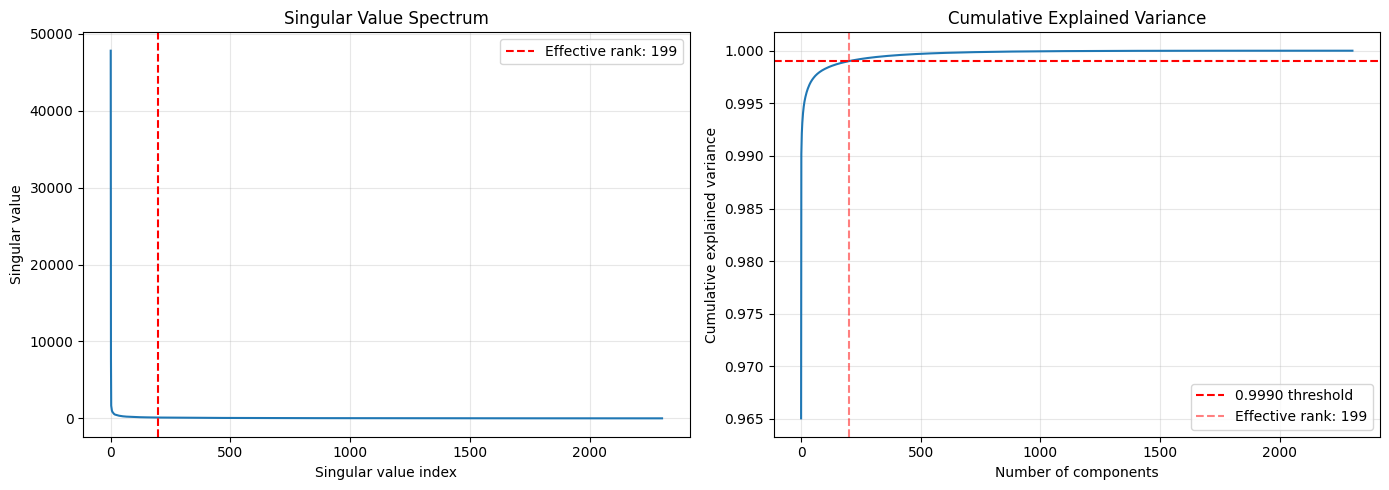

In [16]:
def compute_effective_rank(tensor: th.Tensor, threshold: float = 0.99) -> tuple[int, th.Tensor]:
    """
    Compute effective rank of a tensor using SVD.
    
    Args:
        tensor: Input tensor of shape (batch, seq_len, d_model)
        threshold: Cumulative variance threshold for determining effective rank (default: 0.99)
    
    Returns:
        Tuple of (effective_rank, singular_values)
    """
    # Reshape to (batch * seq_len, d_model)
    B, L, D = tensor.shape
    X = tensor.reshape(B * L, D).cpu().float()
    
    # Compute SVD
    _, S, _ = th.linalg.svd(X, full_matrices=False)
    
    # Compute explained variance ratio
    variance = S ** 2
    variance_ratio = variance / variance.sum()
    cumsum_variance = th.cumsum(variance_ratio, dim=0)
    
    # Find effective rank (first index where cumsum exceeds threshold)
    effective_rank = (cumsum_variance < threshold).sum().item() + 1
    
    return effective_rank, S


thresh = 0.999

# Compute effective rank of predictable reconstructions
pred_recons_flat = pred_recons  # Shape: (batch, seq_len, d_model)
effective_rank, singular_values = compute_effective_rank(pred_recons_flat, threshold=thresh)

print(f"\nEffective rank of predictable reconstructions: {effective_rank}")
print(f"Total dimensions (d_model): {pred_recons_flat.shape[-1]}")
print(f"Rank compression ratio: {effective_rank / pred_recons_flat.shape[-1]:.4f}")

# Plot singular value spectrum
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot singular values
axes[0].plot(singular_values.numpy())
axes[0].axvline(x=effective_rank, color='r', linestyle='--', label=f'Effective rank: {effective_rank}')
axes[0].set_xlabel('Singular value index')
axes[0].set_ylabel('Singular value')
axes[0].set_title('Singular Value Spectrum')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot cumulative explained variance
variance = singular_values ** 2
variance_ratio = variance / variance.sum()
cumsum_variance = th.cumsum(variance_ratio, dim=0)

axes[1].plot(cumsum_variance.numpy())
axes[1].axhline(y=thresh, color='r', linestyle='--', label=f'{thresh:.4f} threshold')
axes[1].axvline(x=effective_rank, color='r', linestyle='--', alpha=0.5, label=f'Effective rank: {effective_rank}')
axes[1].set_xlabel('Number of components')
axes[1].set_ylabel('Cumulative explained variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyzing local information via Novel Codes

def compute_variance_explained(reconstruction: th.Tensor, target: th.Tensor) -> th.Tensor:
    """
    Compute variance explained by a reconstruction.

    Args:
        reconstruction: Reconstructed activations
        target: Original activations to compare against

    Returns:
        Variance explained (1 - MSE / variance)
    """
    mse = th.mean((reconstruction - target) ** 2)
    variance = target.to(th.float32).var()
    return 1 - mse / variance


def compute_l0_sparsity(codes: th.Tensor) -> th.Tensor:
    """
    Compute L0 sparsity (number of non-zero elements) for codes.

    Args:
        codes: Feature codes tensor

    Returns:
        L0 sparsity (count of non-zero elements along last dimension)
    """
    return (codes != 0.0).sum(-1)


def compute_95_ci(tensor: th.Tensor) -> tuple[float, float]:
    """
    Compute 95% confidence interval for a tensor.

    Args:
        tensor: Input tensor

    Returns:
        Tuple of (lower_bound, upper_bound) for 95% CI
    """
    lower = th.quantile(tensor.float(), 0.025).item()
    upper = th.quantile(tensor.float(), 0.975).item()
    return lower, upper


# Run SAE
recons, results = sae(activations)

# Get codes and reconstructions
novel_codes = results['novel_codes']
pred_codes = results['pred_codes']
total_codes = novel_codes + pred_codes
novel_recons = results['novel_recons']
pred_recons = results['pred_recons']

print(novel_codes.shape)

# Check reconstruction quality
variance_explained_total = compute_variance_explained(recons[:, 1:], activations[:, 1:])
variance_explained_novel = compute_variance_explained(novel_recons[:, 1:], activations[:, 1:])
variance_explained_pred = compute_variance_explained(pred_recons[:, 1:], activations[:, 1:])

print(f"\nVariance explained (total): {variance_explained_total:.4f}")
print(f"Variance explained (novel): {variance_explained_novel:.4f}")
print(f"Variance explained (pred): {variance_explained_pred:.4f}")

# Check sparsity (L0)
l0_novel = compute_l0_sparsity(novel_codes)
l0_pred = compute_l0_sparsity(pred_codes)
l0_total = compute_l0_sparsity(total_codes)

# Compute mean and 95% CI for L0
l0_novel_mean = l0_novel.float().mean().item()
l0_novel_ci = compute_95_ci(l0_novel)
l0_pred_mean = l0_pred.float().mean().item()
l0_pred_ci = compute_95_ci(l0_pred)

print(f"\nL0 (novel): {l0_novel_mean:.1f} (95% CI: [{l0_novel_ci[0]:.1f}, {l0_novel_ci[1]:.1f}])")
print(f"L0 (predictable): {l0_pred_mean:.1f} (95% CI: [{l0_pred_ci[0]:.1f}, {l0_pred_ci[1]:.1f}])")

# Novel Codes

In [13]:
val, ind = novel_codes.max(dim=-1)
selected_feature_idx = ind[0, -2] # Token position "_sky"

print(f"Selected token: {token_list[-2]}")

Selected token: ▁sky


In [14]:
## Feature Dashboard Visualization
from IPython.display import IFrame

html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(sae_release="gemma-2-2b", sae_id="12-temporal-res", feature_idx=0):
    """Generate Neuronpedia dashboard URL for a specific feature."""
    return html_template.format(sae_release, sae_id, feature_idx)

example_feature_idx = 0 # Interpretation: proper noun (last token)
example_feature_idx = 1 # Interpretation: optimism
example_feature_idx = 2 # Interpretation: manipulation

html = get_dashboard_html(
    sae_release="gemma-2-2b",
    sae_id="12-temporal-res",  # Adjust this to match your SAE on Neuronpedia if available
    feature_idx=selected_feature_idx
)

print(f"Displaying dashboard for feature {example_feature_idx}")
IFrame(html, width=1200, height=600)

Displaying dashboard for feature 2


# Predictive Codes

In [ ]:
# Example prompt
prompt = "Once upon a time, a little girl named Alice loved looking at the night sky."

In [ ]:
# Tokenize
inputs = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to(device)
token_list = tokenizer.convert_ids_to_tokens(inputs[0])
print(f"Input shape: {inputs.shape}")
print(f"Tokens: {token_list}")

# Extract activations at layer 12
target_layer = 12
activations = gather_residual_activations(model, target_layer, inputs)
print(f"\nActivations shape: {activations.shape}") 

Input shape: torch.Size([1, 18])
Tokens: ['<bos>', 'Once', '▁upon', '▁a', '▁time', ',', '▁a', '▁little', '▁girl', '▁named', '▁Alice', '▁loved', '▁looking', '▁at', '▁the', '▁night', '▁sky', '.']

Activations shape: torch.Size([1, 18, 2304])


In [ ]:
# Run SAE
recons, results = sae(activations)

# Get codes
novel_codes = results['novel_codes']
pred_codes = results['pred_codes']
total_codes = novel_codes + pred_codes

# Check reconstruction quality
variance_explained = 1 - th.mean((recons[:, 1:] - activations[:, 1:]) ** 2) / (activations[:, 1:].to(th.float32).var())
print(f"\nVariance explained: {variance_explained:.4f}")

# Check sparsity (L0)
l0_novel = (novel_codes != 0.0).sum(-1)
l0_pred = (pred_codes != 0.0).sum(-1) # Pred codes can be negative
l0_total = (total_codes != 0.0).sum(-1)

print(f"\nL0 (novel): {l0_novel.squeeze().tolist()}")
print(f"L0 (predictable): {l0_pred.squeeze().tolist()}")

Reconstruction shape: torch.Size([1, 18, 2304])
Novel codes shape: torch.Size([1, 18, 9216])
Predictable codes shape: torch.Size([1, 18, 9216])

Variance explained: 0.9343

L0 (novel): [192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192]
L0 (predictable): [880, 791, 2689, 2762, 2808, 2811, 2776, 2763, 2737, 2726, 2745, 2746, 2694, 2671, 2680, 2681, 2684, 2685]


## Compute Similarity Matrix

In [15]:
# Compute pairwise cosine similarity between predictable codes across tokens
# Extract pred_codes for batch_idx = 0
pred_LD = pred_codes[0]  # Shape: [L, D] where L=sequence_length, D=width

# Center the predictions
pred_centered_LD = pred_LD - th.mean(pred_LD, dim=0, keepdim=True)

# Normalize along the D dimension
pred_LD_normalized = F.normalize(pred_centered_LD.float(), p=2, dim=-1)  # L x D, normalized along D

# Compute cosine similarity: pred_LD @ pred_LD.T -> L x L
cosine_sim_LL = pred_LD_normalized @ pred_LD_normalized.T
cosine_sim_np = cosine_sim_LL.cpu().numpy()

print(f"Similarity matrix shape: {cosine_sim_LL.shape}")
print(f"Min similarity: {cosine_sim_LL.min():.4f}")
print(f"Max similarity: {cosine_sim_LL.max():.4f}")
print(f"Mean similarity: {cosine_sim_LL.mean():.4f}")

Similarity matrix shape: torch.Size([18, 18])
Min similarity: -0.9001
Max similarity: 1.0000
Mean similarity: 0.5123


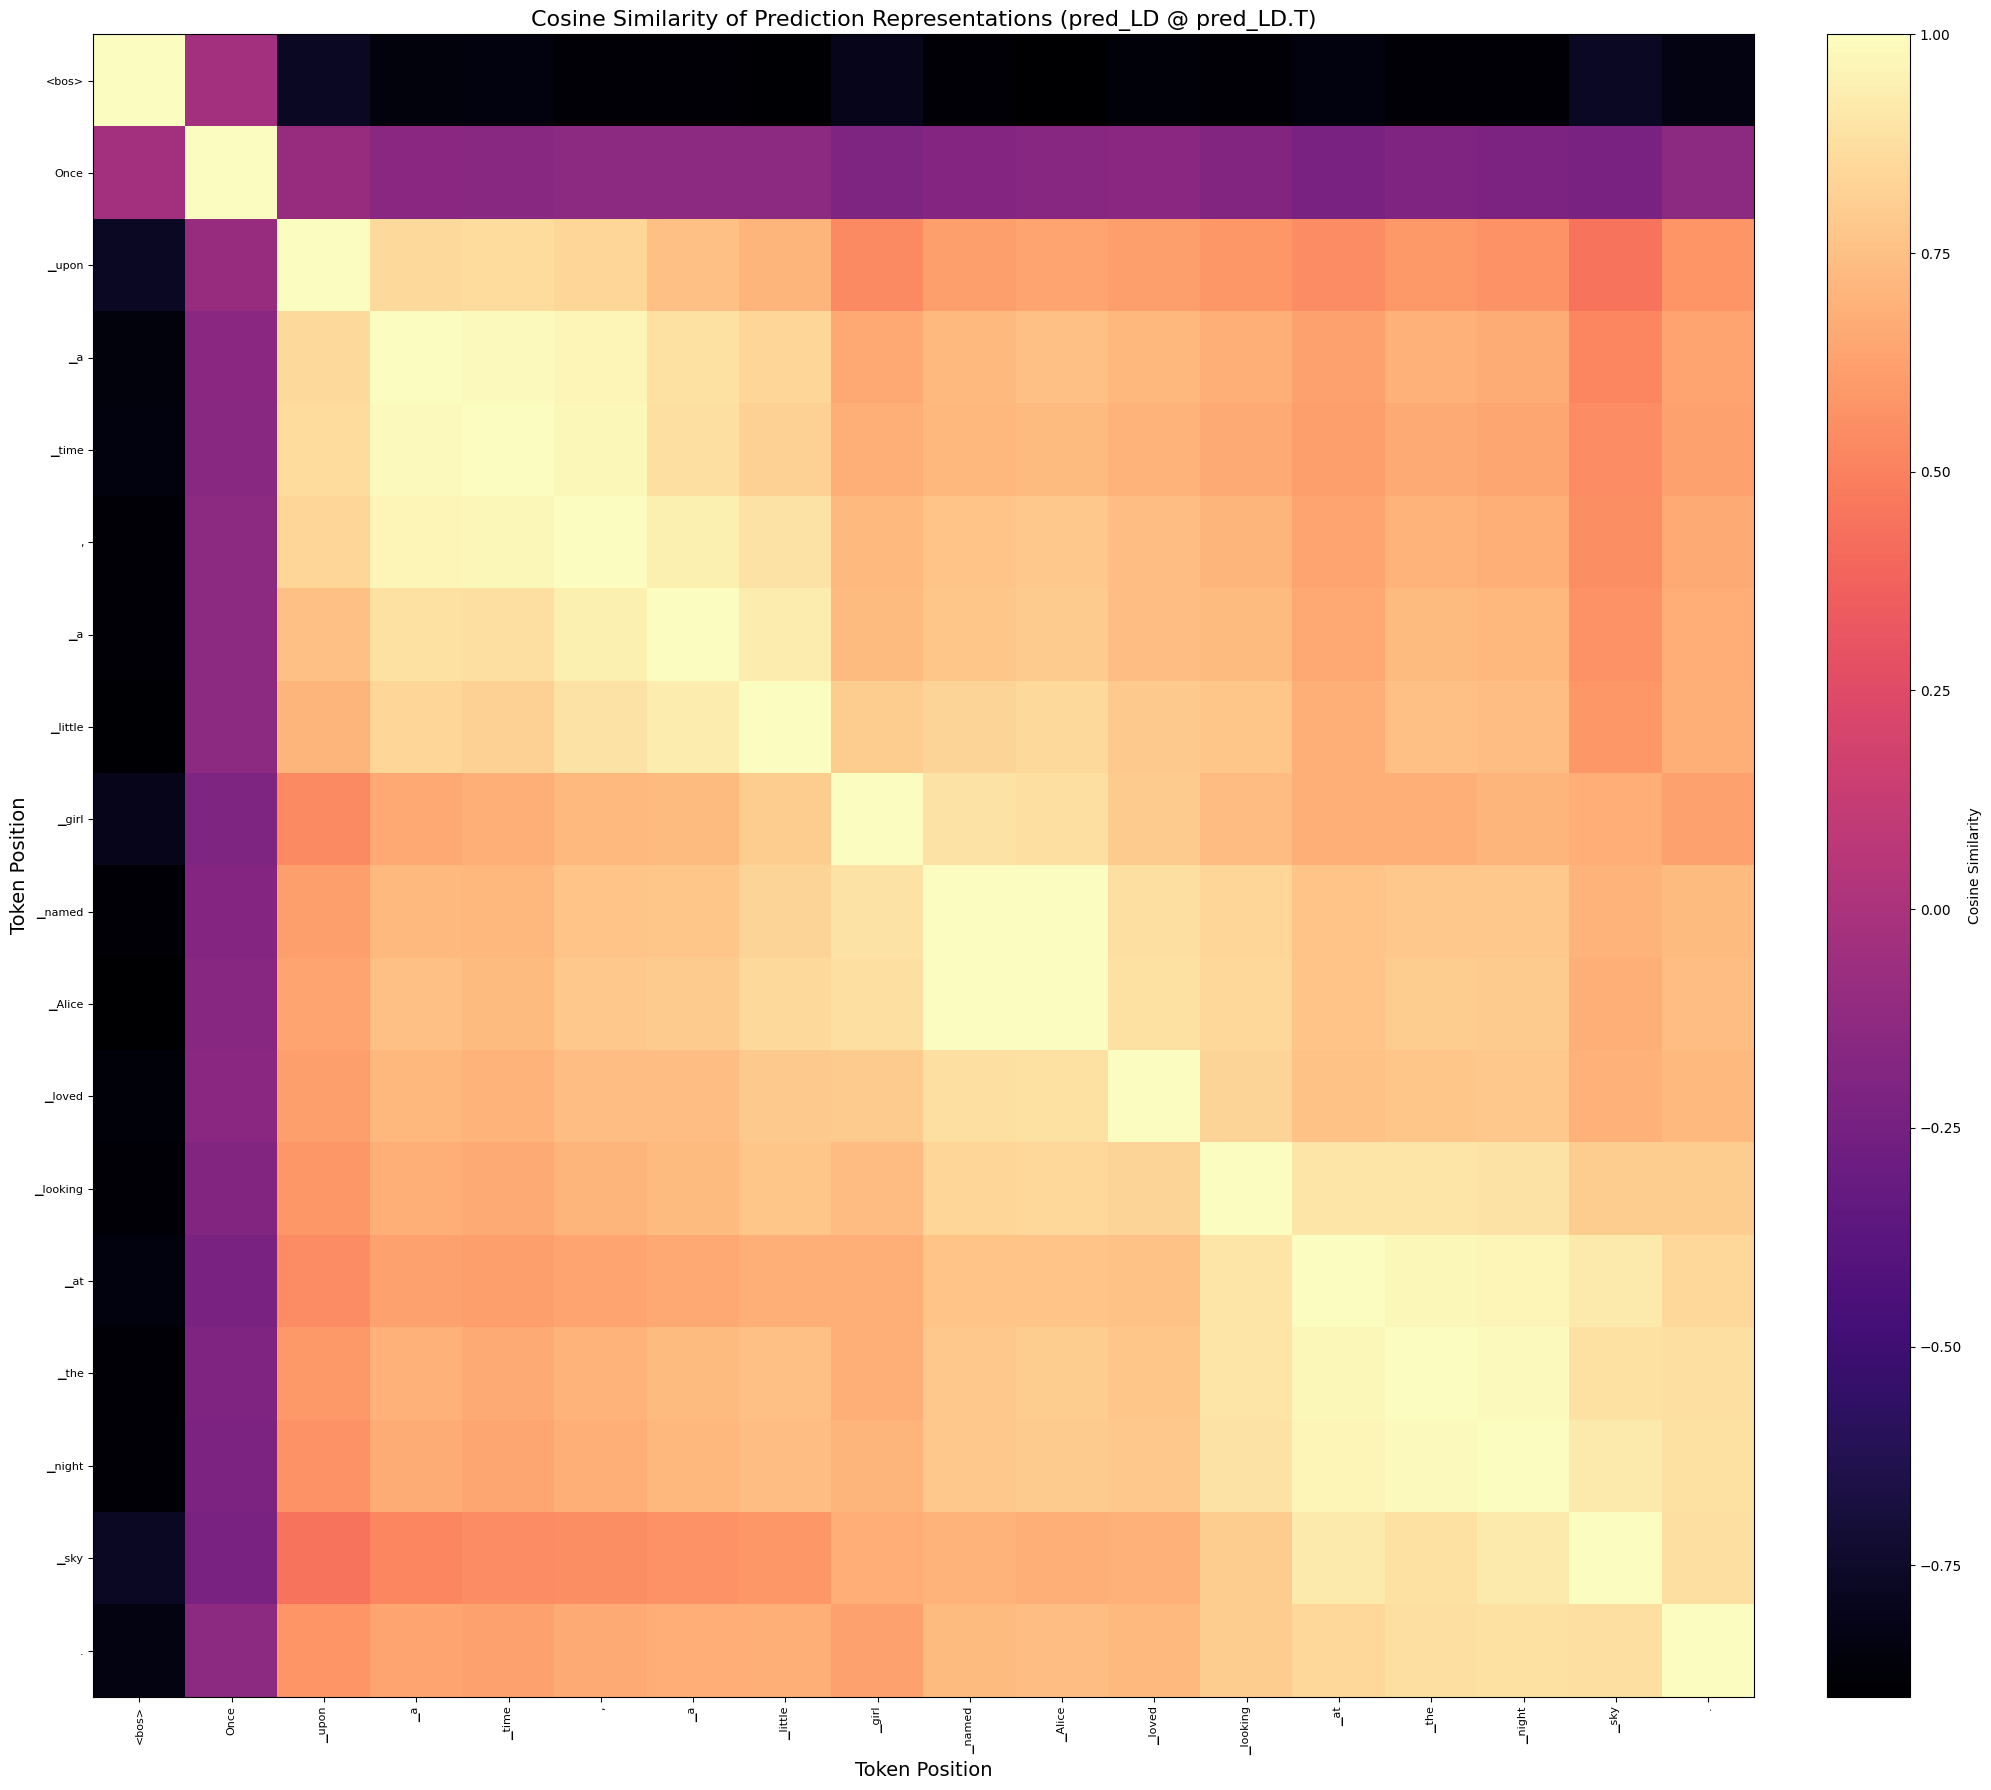

In [16]:
import matplotlib.pyplot as plt
import numpy as np

vmin = None
vmax = None

# Get token strings for labels
token_str_L = tokenizer.convert_ids_to_tokens(inputs[0])

# Create a large figure to accommodate token labels
L = len(token_str_L)
fig, ax = plt.subplots(figsize=(max(20, L * 0.5), max(18, L * 0.5)))

# Plot heatmap
im = ax.imshow(cosine_sim_np, cmap='magma', aspect='auto', vmin=vmin, vmax=vmax)

# Set tick labels to tokens
ax.set_xticks(range(L))
ax.set_yticks(range(L))
ax.set_xticklabels(token_str_L, rotation=90, ha='center', fontsize=8)
ax.set_yticklabels(token_str_L, fontsize=8)

# Labels and title
ax.set_xlabel('Token Position', fontsize=14)
ax.set_ylabel('Token Position', fontsize=14)
ax.set_title('Cosine Similarity of Prediction Representations (pred_LD @ pred_LD.T)', fontsize=16)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Cosine Similarity')

plt.tight_layout()
plt.show()

In [17]:
html_similarity_viewer = "https://www.neuronpedia.org/gemma-2-2b/12-temporal-res?simMatrixDemo=alice-maya"
IFrame(html_similarity_viewer, width=1200, height=600)

## UMAP Visualization

In [18]:
from umap import UMAP
import numpy as np

# UMAP Configuration
n_components = 3  # 3D visualization
n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
random_state = 42

# Position subsampling (since we only have 20 tokens, use all of them)
min_p = 0
max_p = pred_codes.shape[1] - 1  # Last position index
num_p = min(pred_codes.shape[1], 20)  # Sample up to 20 positions

# Compute position indices
ps = th.linspace(min_p, max_p, num_p, dtype=th.int)
print(f"Position indices: {ps.tolist()}")

# Subsample pred_codes at selected positions
# pred_codes shape: (batch, seq_len, width)
act_BLD_subsampled = pred_codes[:, ps, :]  # (batch, num_p, width)

# Flatten for UMAP: (batch * num_p, width)
B, L, D = act_BLD_subsampled.shape
X = act_BLD_subsampled.reshape(B * L, D).cpu().float().numpy()

# Initialize and fit UMAP
reducer = UMAP(
    n_components=n_components,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    metric=metric,
    random_state=random_state,
)

embedding_np = reducer.fit_transform(X)
embedding = th.from_numpy(embedding_np).reshape(B, L, -1)
print(f"UMAP embedding shape: {embedding.shape}")

Position indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: torch.Size([1, 18, 3])


In [19]:
import plotly.graph_objects as go

# Generate hover texts with token context
hover_window = 500  # Number of tokens to show before current position
hover_texts = []

token_strs_L = tokenizer.convert_ids_to_tokens(inputs[0])

for b_idx in range(B):
    for l_idx_in_seq, pos_idx in enumerate(ps.tolist()):
        # Show previous hover_window tokens + current token (bolded)
        start_idx = max(0, pos_idx - hover_window)
        end_idx = min(len(token_strs_L), pos_idx + 1)

        story_str = ""
        token_count = 0
        for i in range(start_idx, end_idx):
            t = token_strs_L[i]

            # Add linebreak every 15 tokens
            if token_count > 0 and token_count % 15 == 0:
                story_str += "<br>"

            if i == pos_idx:
                story_str += f"<b>{t}</b>"  # Bold the current token
            else:
                story_str += t

            token_count += 1

        hover_texts.append(f"Position: {pos_idx}<br>Story: {story_str}")

# Flatten embedding and position labels for plotting
embedding_flat = embedding.reshape(-1, n_components).numpy()
pos_labels_flat = ps.repeat(B).numpy()

# Create 3D scatter plot
if n_components == 3:
    traces = [
        go.Scatter3d(
            x=embedding_flat[:, 0],
            y=embedding_flat[:, 1],
            z=embedding_flat[:, 2],
            mode="markers",
            marker=dict(
                size=5,
                color=pos_labels_flat,
                colorscale="Viridis",
                showscale=True,
                colorbar=dict(title="Position Index"),
                opacity=0.8,
            ),
            text=hover_texts,
            hovertemplate="%{text}<br>UMAP1: %{x:.2f}<br>UMAP2: %{y:.2f}<br>UMAP3: %{z:.2f}<extra></extra>",
        )
    ]

    # Add sequence connection lines
    for b in range(B):
        traces.append(
            go.Scatter3d(
                x=embedding[b, :, 0].numpy(),
                y=embedding[b, :, 1].numpy(),
                z=embedding[b, :, 2].numpy(),
                mode="lines",
                line=dict(color="black", width=2),
                opacity=0.3,
                showlegend=False,
                hoverinfo="skip",
            )
        )

    fig = go.Figure(data=traces)
    fig.update_layout(
        title="UMAP of Temporal Predictive Codes (colored by position)",
        scene=dict(xaxis_title="UMAP 1", yaxis_title="UMAP 2", zaxis_title="UMAP 3"),
        width=1000,
        height=800,
    )

elif n_components == 2:
    traces = [
        go.Scatter(
            x=embedding_flat[:, 0],
            y=embedding_flat[:, 1],
            mode="markers",
            marker=dict(
                size=8,
                color=pos_labels_flat,
                colorscale="Viridis",
                showscale=True,
                colorbar=dict(title="Position Index"),
                opacity=0.6,
            ),
            text=hover_texts,
            hovertemplate="%{text}<br>UMAP1: %{x:.2f}<br>UMAP2: %{y:.2f}<extra></extra>",
        )
    ]

    # Add sequence connection lines
    for b in range(B):
        traces.append(
            go.Scatter(
                x=embedding[b, :, 0].numpy(),
                y=embedding[b, :, 1].numpy(),
                mode="lines",
                line=dict(color="black", width=2),
                opacity=0.3,
                showlegend=False,
                hoverinfo="skip",
            )
        )

    fig = go.Figure(data=traces)
    fig.update_layout(
        title="UMAP of Temporal Predictive Codes (colored by position)",
        xaxis_title="UMAP 1",
        yaxis_title="UMAP 2",
        width=1000,
        height=800,
    )

fig.show()